In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.linear_model import LinearRegression

from utils.plot_utils import regression_plot_with_uncertainty
from utils.Prediction_bands import(split_conformal_bands,
                                   weighted_conformal_prediction
                                   
)
from concurrent.futures import ThreadPoolExecutor

from scipy.stats import multivariate_normal, norm

# SETTING 2: CHANGEPOINTS
# SETTING 3: Distribution drift
Interpolating $\beta^{(1)} = (2, 1, 0, 0)$ to $\beta^{N} = (0, 0, 2, 1)$

In [51]:
setting = 3

np.random.seed(12345)
N = 2000
alpha = 0.1
methods = ['CP+LS', 'nexCP+LS', 'nexCP+WLS', "gaussian"]
ntrial = 200
train_lag = 100

rho = rho_LS = 0.99

X = np.random.normal(size = (ntrial, N, 4))
noise = np.random.normal(size = (ntrial, N))
Y = np.zeros((ntrial, N))



if setting == 2: 
    changepoints = np.r_[500, 1500]    
    num_changepoints = 2
    beta = np.array([[2, 1, 0, 0], [0, -2, -1, 0], [0, 0, 2, 1]])
    for i in np.arange(1 + num_changepoints):
        if i == 0:
            idx_min = 0
        else:
            idx_min = changepoints[i-1]

        if (i == num_changepoints):
            idx_max = N
        else:
            idx_max = changepoints[i]
            
        Y[:, idx_min:idx_max] = X[:, idx_min:idx_max].dot(beta[i]) + noise[:, idx_min:idx_max]
        
if setting == 3:

    beta_start = np.array([2,1,0,0])
    beta_end = np.array([0,0,2,1])
    beta = beta_start + np.outer(np.arange(N)/(N-1),beta_end-beta_start)

    for i in np.arange(N):
        Y[:, i] = X[:, i].dot(beta[i]) + noise[:, i]

    


In [4]:
np.random.seed(12345)
N = 2000
ntrial = 200
nfeatures = 4

X = np.zeros((ntrial, N, nfeatures))
X[:, 0, :] = np.random.normal(loc=0, scale=1, size=(ntrial, nfeatures))

for i in np.arange(1, N):
    X[:, i, :] = np.random.normal(X[:, i-1, :], scale=1, size=(ntrial, nfeatures))

beta = np.array([1, 2, 5, -1])



perm = np.random.permutation(N)

# X = X[:, perm, :]



for i in np.arange(N):
    Y[:, i] = X[:, i, :].dot(beta) + np.random.normal(loc=0, scale=1, size=ntrial)

# Y = np.sum(X * beta, axis=2) + np.random.normal(loc=0, scale=1, size=(ntrial, N))






methods = ['CP+LS', 'nexCP+LS', 'nexCP+WLS', 'gaussian']
rho = rho_LS = 0.99
alpha = 0.1
train_lag = 500


In [5]:
X.shape

(200, 2000, 4)

If we first have X_i is deterministically drawn: i.e.  X_i = i,  $\forall i \in \mathbb{N}$


And we let 
$$Y_i \sim \mathcal{N}(sin(\frac{X_i}{k}), 1)$$

In [6]:
def generate_data(N, ntrial):
    """
    Generate data for replication setting 2.3.

    Parameters:
    - N (int): The number of elements in the array.
    - ntrial (int): The number of trials.

    Returns:
    - X (ndarray): The generated array X.
    - Y (ndarray): The generated array Y.
    """
    X = np.arange(N).reshape(1, N, 1).repeat(ntrial, axis=0)
    Y = 1 * np.sin(X/2).reshape(ntrial, N)  + np.random.normal(scale=1, size=(ntrial, N))

    return X, Y

# Generate data
N = 2000
ntrial = 200
X, Y = generate_data(N, ntrial)
# perm = np.random.permutation(N)
# Y = Y[:, perm]

In [7]:
Y.shape

(200, 2000)

In [8]:
average_var = np.mean(np.var(Y, axis=1))

In [9]:
h = 1.06 * average_var * N**(-1/5)

In [10]:
h

0.3476155369587352

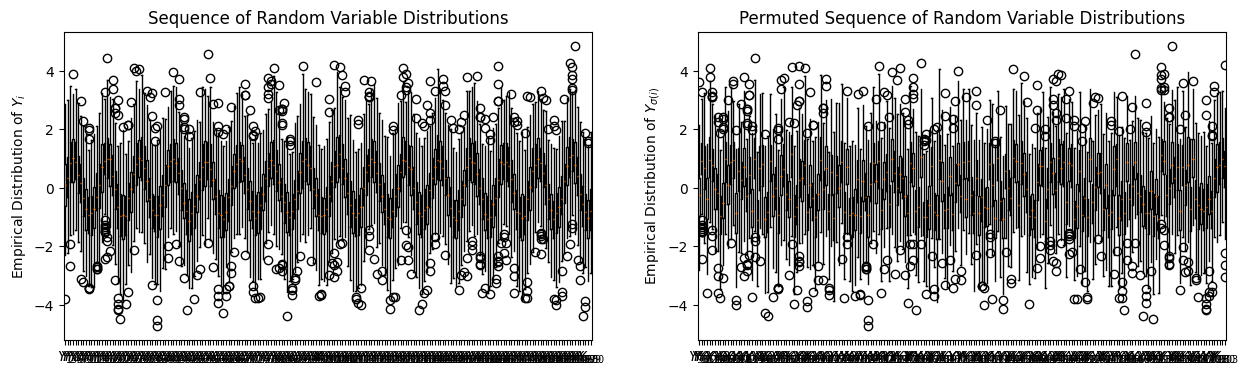

In [11]:
# Indices (1, ..., n+1)
indices = np.arange(0, len(X))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
ax[0].boxplot([Y[:, i] for i in indices])
ax[0].set_xticks(indices+1, [f'$Y_{{ {val+1} }}$' for val in indices])
ax[0].set_ylabel('Empirical Distribution of $Y_i$')
ax[0].set_title('Sequence of Random Variable Distributions')

np.random.seed(42)
# Sample an arbitrary permutation π over (1, ..., n+1)
permutation = np.random.permutation(indices)

ax[1].boxplot(Y[:, indices[permutation]])
ax[1].set_xticks(indices+1, [f'$Y_{{ {val+1} }}$' for val in permutation])
ax[1].set_ylabel('Empirical Distribution of $Y_{\sigma(i)}$')
ax[1].set_title('Permuted Sequence of Random Variable Distributions')

plt.show()

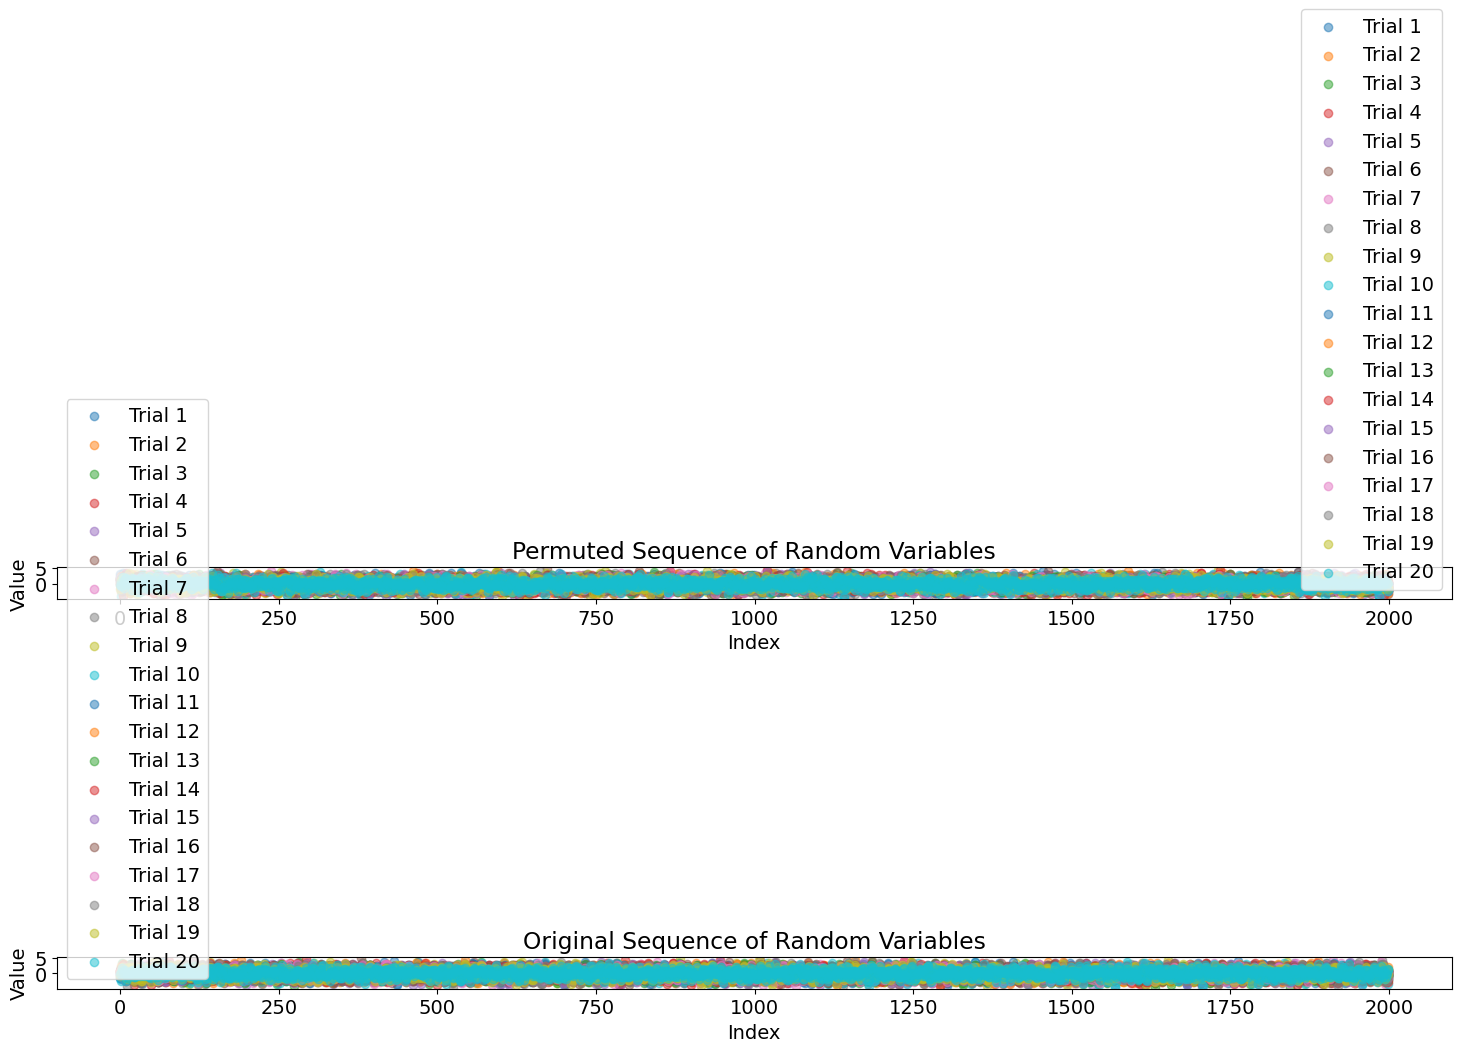

In [136]:
perm = np.random.permutation(N)
permuted_Y = Y[:, perm]

# Indices for x-axis
indices = np.arange(N)

# Plotting
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

# Plot permuted sequence of random variables
for i in range(ntrial):
    ax[0].scatter(indices, permuted_Y[i], alpha=0.5, label=f'Trial {i+1}')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Value')
ax[0].set_title('Permuted Sequence of Random Variables')
ax[0].legend()

# Plot original sequence of random variables
for i in range(ntrial):
    ax[1].scatter(indices, Y[i], alpha=0.5, label=f'Trial {i+1}')
ax[1].set_xlabel('Index')
ax[1].set_ylabel('Value')
ax[1].set_title('Original Sequence of Random Variables')
ax[1].legend()

plt.tight_layout()
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

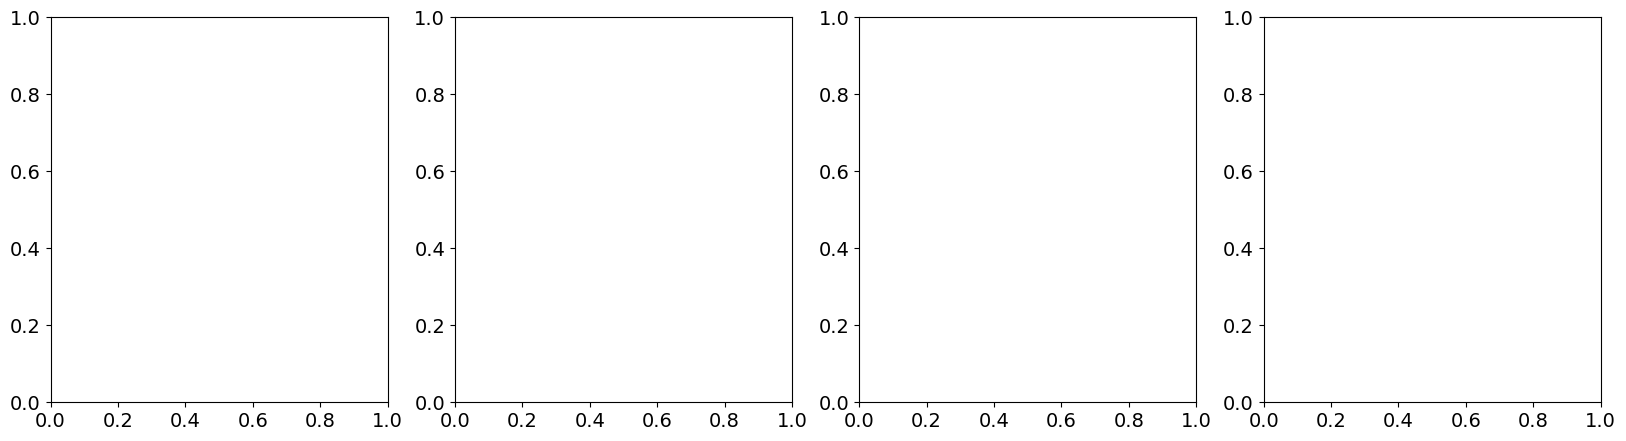

In [114]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for beta_col in range(4):
    ax[beta_col].plot(np.arange(N), beta[:, beta_col])
    ax[beta_col].set_title(r"$\beta_{}$".format(beta_col + 1))
    ax[beta_col].set_xlabel("Time")
    if beta_col == 0:
        ax[beta_col].set_ylabel(r"$\beta$") 
plt.tight_layout()
plt.show()
        

In [64]:
itrial = 1
pred_idx = 1000

X_trial_normalised = (X[itrial, :pred_idx + 1] - np.mean(X[itrial, :pred_idx + 1], axis = 0)) / np.std(X[itrial, :pred_idx + 1], axis = 0)

X_trial_normalised[pred_idx]

1.06 * np.std(X_trial_normalised, axis = 0) * X_trial_normalised.shape[0]**(-1/5)

array([0.26620674, 0.26620674, 0.26620674, 0.26620674])

In [69]:
def run_trial(itrial):
    for pred_idx in np.arange(train_lag, N):

        for method_idx, method in enumerate(methods):
            
            if method in ['nexCP+LS', 'nexCP+WLS']:
            
                weights = rho**(np.arange(pred_idx,0,-1))
            
                weights = np.r_[weights,1]
        
            elif method == "gaussian":
                # h = 5
                                
                X_trial_normalised = (X[itrial, :pred_idx + 1] - np.mean(X[itrial, :pred_idx + 1], axis = 0)) / np.std(X[itrial, :pred_idx + 1], axis = 0)
                
                
                h = 1.06 * np.std(X_trial_normalised, axis = 0) * X_trial_normalised.shape[0]**(-1/5)
                h = h[0]
                
                X_tilde = multivariate_normal.rvs(mean = X_trial_normalised[pred_idx], cov = np.diag(np.ones(4))*h**2)
                
                # Calculate Euclidean distance
                weights = np.exp(-0.5 * np.linalg.norm(X_trial_normalised[:pred_idx] - X_tilde, axis=1) / h**2)
                weights = np.r_[weights,1]
                
            else:
                weights = np.ones(pred_idx+1)
            
            
            if method == 'nexCP+WLS':
             
                tags = rho_LS**(np.arange(pred_idx,-1,-1))
                
            #
            # elif method == 'gaussian':
            #     tags = weights[:-1]
            else:
                tags = np.ones(pred_idx+1)
            
            

            
            # odd data points for training, even ones for calibration
            inds_odd = np.arange(1,int(np.ceil(pred_idx/2)*2-1),2) # excludes pred_idx
            inds_even = np.arange(2,int(np.floor(pred_idx/2)*2),2) # excludes pred_idx

            # train a weighted least squares regression (tags are the weights)
            predictor = LinearRegression()
            predictor.fit(X[itrial, inds_odd], Y[itrial, inds_odd], tags[inds_odd])

            mean_prediction, prediction_bands, _, _ = weighted_conformal_prediction(
                predictor, # the trained weighted linear regression model
                X[itrial, inds_even], # calibration inputs
                Y[itrial, inds_even], # calibration targets
                X[itrial, pred_idx][np.newaxis, :], # test point to predict
                weights[inds_even], # calibration score weights
                alpha # target miscoverage rate
            )
            PI_split_CP[method_idx,itrial,pred_idx,:] = prediction_bands
            
            
            if pred_idx == N - 1:
                weights_noramalised = weights / np.sum(weights)
                all_weights[method_idx, itrial, :len(weights)] = weights_noramalised

In [70]:
PI_split_CP = np.zeros((len(methods),ntrial,N,2))
PI_split_CP[:, :, :train_lag, 0] = -np.inf
PI_split_CP[:, :, :train_lag, 1] = np.inf
all_weights = np.empty((len(methods), ntrial, N), dtype=object)


with ThreadPoolExecutor(max_workers = 5) as executor:
        list(tqdm(executor.map(run_trial, np.arange(ntrial)), total=ntrial))

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [20:39<00:00,  6.20s/it]


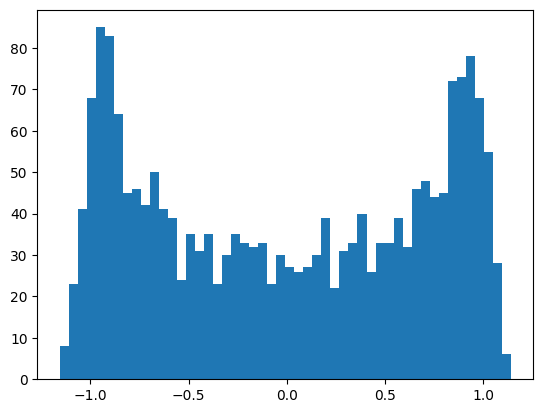

In [36]:
plt.hist(np.mean(Y, axis = 0), bins = 50)
plt.show()

In [37]:
all_weights.shape

(4, 200, 2000)

In [38]:
coverage = np.zeros((len(methods),N - train_lag))
pi_width = np.zeros((len(methods),N - train_lag))


lower_bounds = np.zeros((len(methods),ntrial,N - train_lag))
upper_bounds = np.zeros((len(methods),ntrial,N - train_lag))

for method_idx, method in enumerate(methods):   
    
    if method == "gaussian":
        lower_bound = PI_split_CP[method_idx, :, train_lag:, 0] 
        upper_bound = PI_split_CP[method_idx, :, train_lag:, 1]
        
        lower_bounds[method_idx] = lower_bound
        upper_bounds[method_idx] = upper_bound
        
    else: 
        lower_bound = PI_split_CP[method_idx, :, train_lag:, 0]
        upper_bound = PI_split_CP[method_idx, :, train_lag:, 1]

        lower_bounds[method_idx] = lower_bound
        upper_bounds[method_idx] = upper_bound
    
    coverage[method_idx] = np.mean((lower_bound <= Y[:, train_lag:]) & (upper_bound >= Y[:, train_lag:]), axis=0)
    pi_width[method_idx] = np.mean(upper_bound - lower_bound, axis=0)


In [39]:
methods

['CP+LS', 'nexCP+LS', 'nexCP+WLS', 'gaussian']

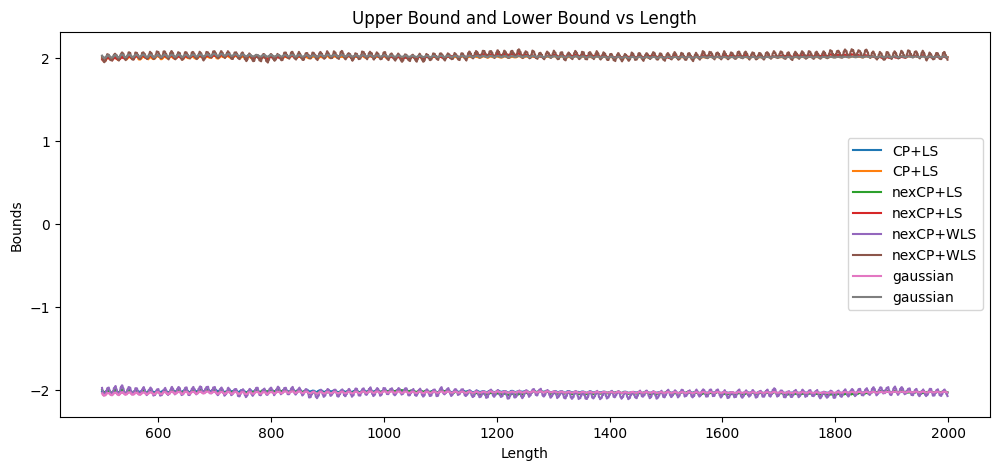

In [40]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

for method_idx, method in enumerate(methods):
    plt.plot(np.arange(train_lag, N), np.mean(lower_bounds[method_idx], axis=0), label=method)
    plt.plot(np.arange(train_lag, N), np.mean(upper_bounds[method_idx], axis=0), label=method)

plt.xlabel('Length')
plt.ylabel('Bounds')
plt.title('Upper Bound and Lower Bound vs Length')
plt.legend()
plt.show()


In [41]:
for method_idx, method in enumerate(methods):
    average_upper_bound = np.mean(upper_bounds[method_idx], axis=0)
    average_lower_bound = np.mean(lower_bounds[method_idx], axis=0)
    
    print(f"The average upper bound for {method} is {average_upper_bound[-1]}")
    print(f"The average lower bound for {method} is {average_lower_bound[-1]}")

The average upper bound for CP+LS is 2.007156424950134
The average lower bound for CP+LS is -2.030637805038738
The average upper bound for nexCP+LS is 2.001947512436952
The average lower bound for nexCP+LS is -2.025428892525554
The average upper bound for nexCP+WLS is 1.9739755461728845
The average lower bound for nexCP+WLS is -2.0715530647974982
The average upper bound for gaussian is 2.004059055637075
The average lower bound for gaussian is -2.027540435725678


In [42]:
lower_bound.shape

(200, 1500)

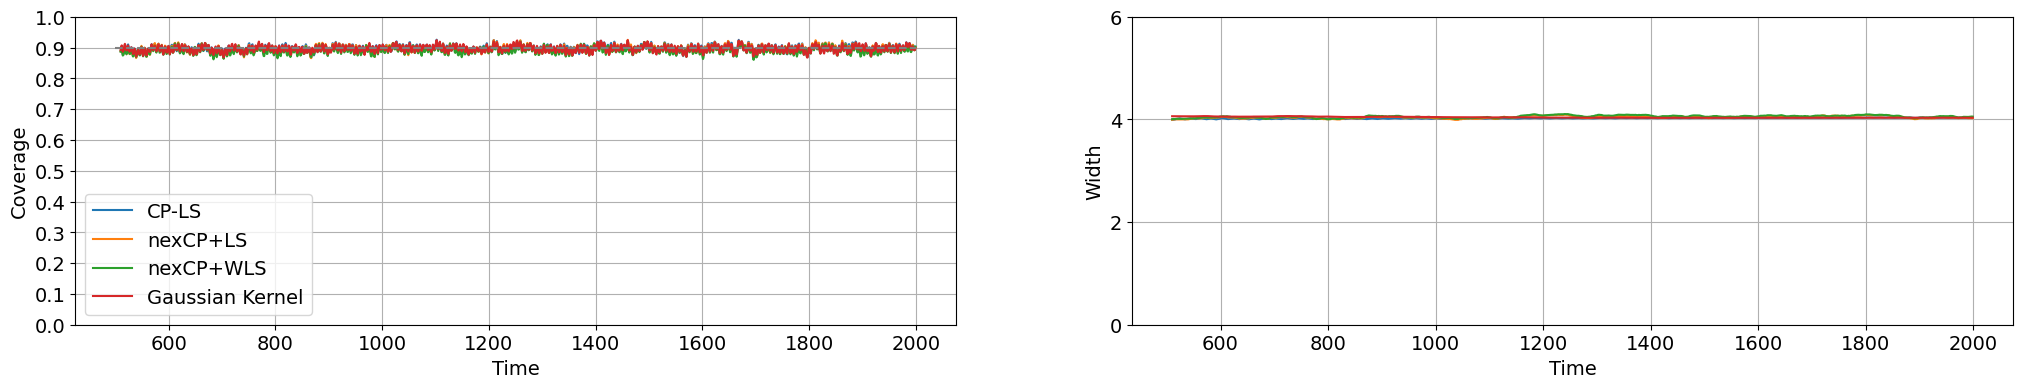

In [43]:
plt.rcParams.update({'font.size': 14})

window = 10 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x, np.ones(window)/window)[(window-1):-window]
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,4))

for method_idx, method in enumerate(methods):
    ax[0].plot(np.arange(train_lag+window,N), rolling_avg(coverage[method_idx], window))
    ax[1].plot(np.arange(train_lag + window, N), rolling_avg(pi_width[method_idx], window))

ax[0].hlines(1-alpha, xmin=train_lag, xmax=N, linestyles='--', colors='gray')
ax[0].legend(['CP-LS','nexCP+LS','nexCP+WLS', "Gaussian Kernel"])

ax[0].set_ylabel('Coverage')
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[0].set_xlabel('Time')
ax[0].grid(True)

ax[1].set_ylabel('Width')
ymax = np.max([
    pi_width[method_idx].max() for method_idx in range(len(methods))
]) * 1.1
ax[1].set_ylim([0, ymax])
ax[1].set_yticks([0, 2, 4, 6])
ax[1].set_xlabel('Time')
ax[1].grid(True)


plt.show()

In [44]:
for method_idx, method in enumerate(methods):
    print(f'{method}')
    print('-'*30)
    print(f'Avg. coverage: {np.mean(coverage[method_idx]):.3f}')
    print(f'Avg. interval width: {np.mean(pi_width[method_idx]):.2f}')
    print()

CP+LS
------------------------------
Avg. coverage: 0.897
Avg. interval width: 4.02

nexCP+LS
------------------------------
Avg. coverage: 0.896
Avg. interval width: 4.04

nexCP+WLS
------------------------------
Avg. coverage: 0.892
Avg. interval width: 4.05

gaussian
------------------------------
Avg. coverage: 0.896
Avg. interval width: 4.04



In [45]:
import pandas as pd
data = {'Method': methods,
    'Avg. Coverage': [np.mean(coverage[method_idx]) for method_idx in range(len(methods))],
    'Avg. Interval Width': [np.mean(pi_width[method_idx]) for method_idx in range(len(methods))]}
df = pd.DataFrame(data)

df.head()


,Method,Avg. Coverage,Avg. Interval Width
0,CP+LS,0.897327,4.023073
1,nexCP+LS,0.895600,4.041746
2,nexCP+WLS,0.891910,4.054445
3,gaussian,0.896147,4.040908


In [46]:
import pyperclip
latex_table = df.to_latex(index=False, float_format="%.3f", column_format="lcc")
pyperclip.copy(latex_table)
print("LaTeX table copied to clipboard.")


LaTeX table copied to clipboard.


In [47]:
all_weights.shape

(4, 200, 2000)

In [59]:
average_weights = np.mean(all_weights, axis=1)
average_weights.shape

(4, 2000)

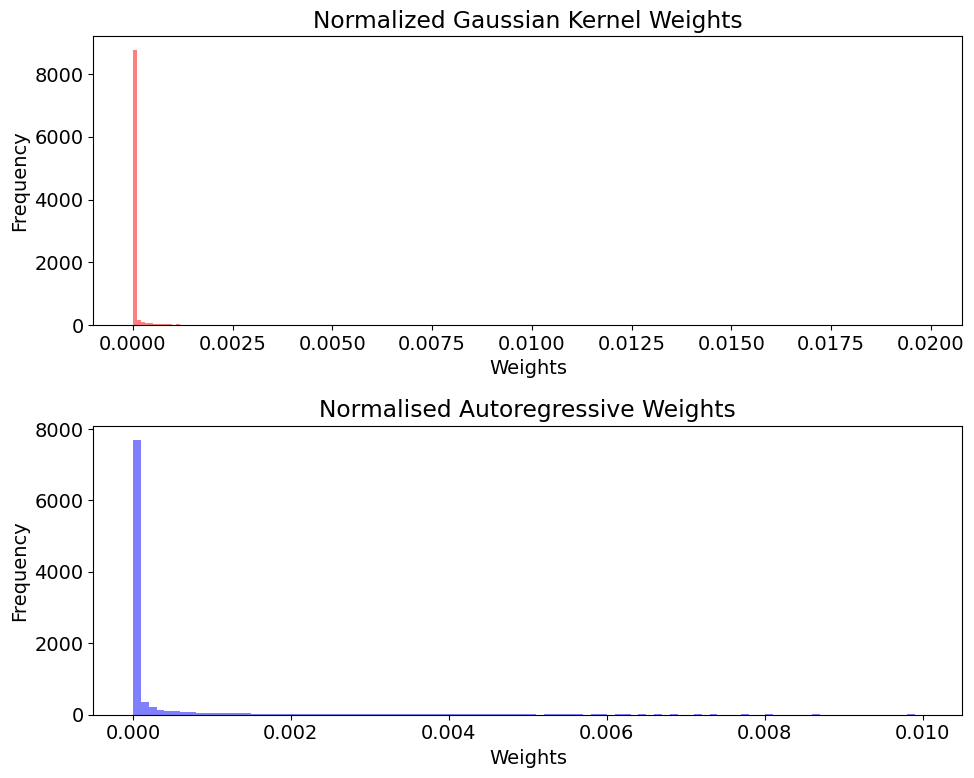

In [60]:
gaussian_weights = average_weights[3, :]
autoregressive_weights = average_weights[2, :]

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].hist(gaussian_weights, bins=200, color='red', alpha=0.5, density=True)
ax[0].set_xlabel("Weights")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Normalized Gaussian Kernel Weights")

ax[1].hist(autoregressive_weights, bins=100, color='blue', alpha=0.5, density=True)
ax[1].set_xlabel("Weights")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Normalised Autoregressive Weights")

plt.tight_layout()
plt.show()


In [61]:
max(gaussian_weights)

0.019801326693244706

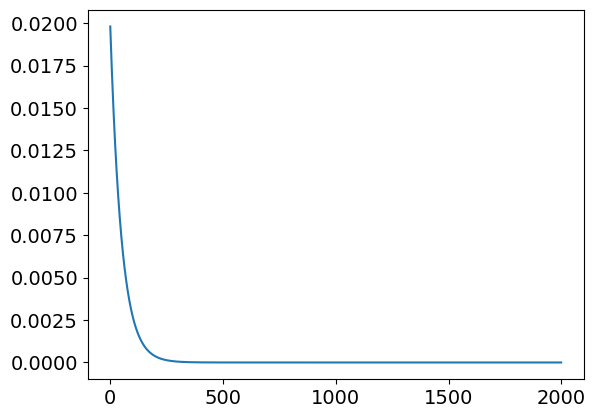

In [69]:
plt.plot(average_weights[3])

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy
from utils.plot_utils import regression_plot_with_uncertainty

In [85]:
Y = Y.reshape(N)
X = X.reshape(N, 1)
predictor = LinearRegression()

pred_idx = 1000




X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)





In [86]:
print(f'Expected number of points outside the 95% error bars: {len(X_cal) * 0.05}')

Expected number of points outside the 95% error bars: 9.0


In [90]:
def construct_prediction_bands(mean_prediction, quantiles):
    """
    A function that returns the lower and upper prediction bands for every quantile in quantiles.
    """
    
    prediction_bands = np.zeros((len(mean_prediction), 2, len(quantiles)))

    for i, q in enumerate(quantiles):
        prediction_bands[:, :, i] = np.stack([
            mean_prediction - q,
            mean_prediction + q
        ], axis=1)

    return prediction_bands

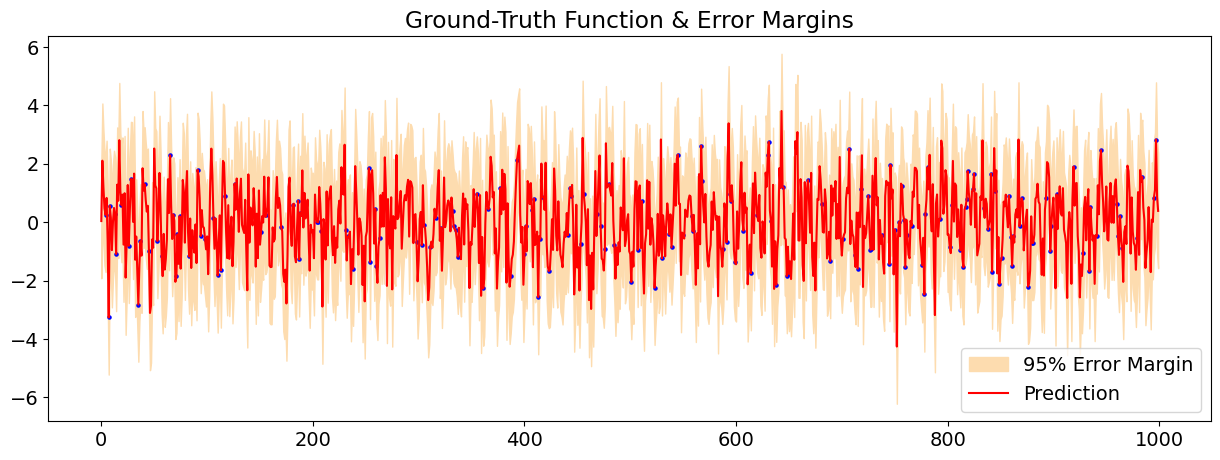

In [97]:
sigma = 1
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# The 97.5th percentile of the standard normal distribution (for \sigma=1.0)
q975 = scipy.stats.norm.ppf(0.975)
# Since we sampled our data using y_gt + N(0, sigma),
# the alpha=0.05 prediction bands should be [y_gt - sigma * q975, y_gt + sigma * q975]
# q025 = -q975 here because the normal distribution is symmetric
prediction_bands = construct_prediction_bands(Y, [sigma * q975])
regression_plot_with_uncertainty(ax, X, Y, prediction_bands, (X_cal, y_cal), labels=['95% Error Margin'])
ax.set_title('Ground-Truth Function & Error Margins')
plt.show()